<div dir=rtl>
در این پروژه قصد داریم با استفاده از روش None negative matrix factorization (NMF) یک سیستم توصیه گر برای دیتاست  Netflix Prize data طراحی کنیم. در ادامه توضیحات تیوری و فرمال این روش آورده شده است.
</div>

<div dir=rtl>
ماتریس V را غیر منفی مینامیم اگر تمام درایه های آن مثبت یا صفر باشد.
با فرض اینکه این ماتریس دارای K سطر و N ستون باشد، این ماترس را میتوان بصورت حاصلضرب دوماتریس با ابعاد K*R و R*N نوشت:

V = W.H

در اینجا پارامتر R بعنوان رنک این فاکتوریزاسیون در نظر گرفته میشود که معمولا بسیار کوچکتر از K و N میباشد. بردارهای ستونی در W بعنوان بردارهای تمپلیت و مقادیر موجود در H بعنوان فعالسازها در نظر گرفته میشوند.

از آنجایی که معمولا برای معادله V = W*H جوابهای زیادی به ازای ماتریس های مختلف W و H وجود دارد، معمولا برای بدست آوردن بهینه ترین جواب از یک روش آپدیت ماترسی ها بصورت ضرب شونده استفاده میشود. در این روش آپدیت پارامترها، هر کدام از این دو ماتریس بصورت جداگانه آپدیت میشود و معیار توقف آموزش 2 حالت است. یا تعداد دوره های آموزش به پایان میرسد، و یا فاصله اقلیدسی هر کدام از این ماتریس ها از حالت قبل خودشان، کمتر از یک مقدار تعیین شده است
</div>

<div dir=rtl>
مراحل آموزش این مدل به شرح زیر است:

1. ماتریس های W و H بصورت رندوم مقداردهی اولیه میشوند.
2. این ماتریس ها برای استپ بعدی بصورت زیر محاسبه میشوند:

        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

3. فاصله اقلیدسی این دو ماتریس با خودشان در استپ قبلی محاسبه میشود و اگر این فاصله در یکی از این دو کمتر از یک مقدار تعیین شده باشد، آموزش متوقف میشود در غیر اینصورت به مرحله 2 بازمیگردیم.
</div>

<div dir=rtl>
همانطور که در بالاتر ذکر شد، داده مورد استفاده در این کار  Netflix Prize data میباشد. این دیتاست مربوط به امتیاز دهی کاربران نتفلیکس بر رو فیلمهای منتشر شده از سال 1890 تا 2005 میباشد. پس از خواندن و اعمال یکسری پیش پردازشها، این داده دازای 4 فیلد مختلف است:

1. آی دی فیلم ها
2. آیدی کاربرها
3. امتیاز تخصیص داده شده توسط کاربر 
4. تاریخ منتشر شدن فیلم

منتها در این پروژه صرفا از 3 فیلد اولی استفاده شده است. در این دیتاست مجموعا 17770 عنوام فیلم و 480189 کاربر یکتا وجود دارد. بواسطه بالا بودن حجم متغیرها هنگام آموزش این مدل صرفا از  بخشی از داده ها (1 میلیون سه تایی آیدی فیلم - آیدی کاربر- امتیاز کاربر ) مورد استفاده قرار گرفته است
</div>

<div dir=rtl>
در سه سلول بعدی دیتاست از سایت کگل دانلود شده است
</div>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download netflix-inc/netflix-prize-data

 99% 676M/683M [00:06<00:00, 112MB/s] 
100% 683M/683M [00:06<00:00, 114MB/s]


In [3]:
!unzip netflix-prize-data.zip -d data

Archive:  netflix-prize-data.zip
  inflating: data/README             
  inflating: data/combined_data_1.txt  
  inflating: data/combined_data_2.txt  
  inflating: data/combined_data_3.txt  
  inflating: data/combined_data_4.txt  
  inflating: data/movie_titles.csv   
  inflating: data/probe.txt          
  inflating: data/qualifying.txt     


<div dir=rtl>
در این سلول کتابخانه های مورد استفاده ایمپورت شده است
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<div dir=rtl>
در این سلول سه تایع تعریف شده است.

تایع read_data برای تبدیل دیتاست به فرم ثابت (دیتافریم) نوشته شده است. در این تابع فایل های متنی جداگانه که حاوی دیتا اصلی میباشد خوانده شده و پس از تجمیع در یک دیتافریم برگشت داده شده است.

تابع data_to_matrix دیتاست را به ماتریسهای اسپارس تبدیل میکند.

تابع rmse خطای پیشبینی را برای محاسبه میکند.

تابع nmf الگوریتم اصلی پیاده سازی شده میباشد.

تابع recommend نام کاربری کاربر را بهمراه ماتریس اصلی و پیشبینی شده دریافت کرده و بع تعداد تعیین شده آیدی فیلم های پیشنهادی را در یک لیست برمیگرداند.


</div>

In [69]:
def read_data(files, title_path):

    data = open('data.csv', mode='w')
    row = list()

    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:] 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')

    data.close()

    df = pd.read_csv('data.csv', header=None, nrows = 1000000).iloc[:, :-1]
    df.columns = ['UserID', 'MovieID', 'Rating']

    movie_map = {a:i for i, a in enumerate(sorted(df['MovieID'].unique()))}
    user_map = {a:i for i, a in enumerate(sorted(df['UserID'].unique()))}

    df['MovieID'] = df['MovieID'].map(lambda a:movie_map[a])
    df['UserID'] = df['UserID'].map(lambda a:user_map[a])
    
    
    
    return df

def data_to_matrix(x, y, m_shape):

    M = sparse.csr_matrix((y,(x[:, 0], x[:, 1])), shape=(m_shape[0],m_shape[1])).toarray()  

    return M.T

def rmse(true, pred):

    pred = pred[true != 0].flatten()
    true = true[true != 0].flatten()
    
    return np.sqrt(mean_squared_error(true, pred))

def nmf(V, R, thresh=0.001, L=1000):

    H_ERROR = []
    W_ERROR = []

    K = V.shape[0]
    N = V.shape[1]

    W = np.random.rand(K, R)
    H = np.random.rand(R, N)

    V = V.astype(np.float64)
    W = W.astype(np.float64)
    H = H.astype(np.float64)
    ell = 1
    below_thresh = False
    eps_machine = np.finfo(np.float32).eps

    while not below_thresh and ell <= L:
        H_ell = H
        W_ell = W
        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

        H_error = np.linalg.norm(H-H_ell, ord=2)
        W_error = np.linalg.norm(W - W_ell, ord=2)

        H_ERROR.append(H_error)
        W_ERROR.append(W_error)

        if H_error < thresh and W_error < thresh:
            below_thresh = True
        ell += 1
    
    return W, H, W_ERROR, H_ERROR

def recommend(user_id, matrix, pred_matrix, num_of_rec):

    pred_user = pred_matrix[:, user_id]
    true_user = matrix[:, user_id]

    rec_dict = dict()

    for i, val in enumerate(true_user):
        if val == 0 and pred_user[i] != 0:
            rec_dict[i] = pred_user[i]

    rec_dict = dict(sorted(rec_dict.items(), key=lambda item: item[1]))
    rec_movie_id = list(rec_dict.keys())[-num_of_rec:]

    print(f"recommended movie id: {rec_movie_id}")

<div dir=rtl>
در این سلول پس از خواندن داده ها، به تست و ترین تقسیم شده و ماتریسهای تستو ترین محاسبه میشوند.
</div>

In [3]:
data = read_data(['data/combined_data_1.txt', 'data/combined_data_2.txt', 'data/combined_data_3.txt', 'data/combined_data_4.txt'], 'data/movie_titles.csv')
matrix_shape = (len(data['UserID'].unique()), len(data['MovieID'].unique()))


X = data[['UserID','MovieID']].values
y = data['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X = None
y = None

train_matrix = data_to_matrix(X_train, y_train, matrix_shape)
test_matrix = data_to_matrix(X_test, y_test, matrix_shape)

data.head()

,UserID,MovieID,Rating
0,0,159639,3
1,0,88366,5
2,0,95010,4
3,0,3228,4
4,0,88509,3


<div dir=rtl>
تعداد کاربرها و فیلم های یکتا در این قسمت مورد بررسی از دیتاست پرینت میشود.
</div>

In [4]:
print(f"number of unique user : {len(data['UserID'].unique())}")
print(f"number of unique movie: {len(data['MovieID'].unique())}")

number of unique user : 225
number of unique movie: 283705


<div dir=rtl>
در این سلول هیستوگرام امتیازهای داده شده توسط کاربران ترسیم شده است.
</div>

Text(0, 0.5, 'frequency')

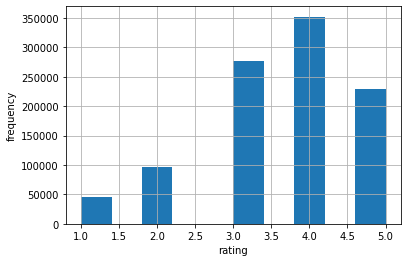

In [5]:
data['Rating'].hist(grid=True)
plt.xlabel('rating')
plt.ylabel('frequency')

<div dir=rtl>
در این سلول هیستوگرام مربوط به تعداد فیلم های امتیاز داده شده توسط هرکدام از کاربرها ترسیم شده است.
</div>

Text(0, 0.5, 'number of movie')

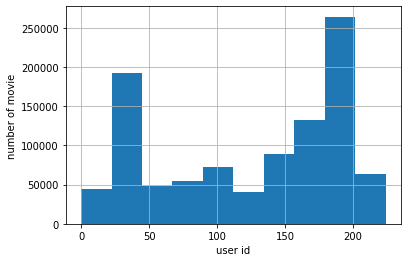

In [6]:
data['UserID'].hist(grid=True)
plt.xlabel('user id')
plt.ylabel('number of movie')

<div dir=rtl>
در این سلول مدل آموزش دیده و ماتریس های مورد نظر و تغییرات خطای آنها برگشت داده شده است. 
</div>

In [63]:
W, H, W_ERROR, H_ERROR = nmf(train_matrix, 20)

<div dir=rtl>
در این سلول تاریخچه تغییرات خطای دو ماتریس W و H ترسیم شده است. 
</div>

[Text(0, 0.5, 'error'), Text(0.5, 0, 'period')]

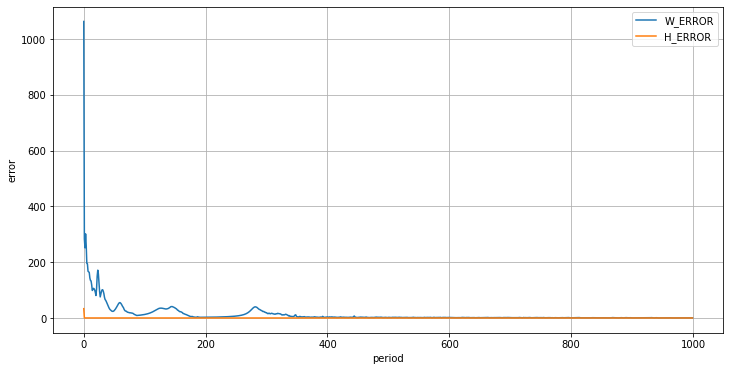

In [64]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(W_ERROR, label = 'W_ERROR')
ax.plot(H_ERROR, label = 'H_ERROR')
ax.grid()
ax.legend()
ax.set(xlabel='period', ylabel='error')

<div dir=rtl>
در این سلول خطای پیشبینی محاسبه شده است. 
</div>

In [65]:
pred = W.dot(H)
print(f"model rmse: {round(rmse(test_matrix, pred), 4)}")

model rmse: 3.718


<div dir=rtl>
در دو سلول بعدی دو کاربر بصورت تصادفی انتخاب شده و ریکامندیشن برای آنها انجام شده است.
</div>

In [66]:
user_id = 23
num_of_rec = 3

recommend(user_id, train_matrix, pred, num_of_rec)

recommended movie id: [140575, 129226, 5316]


In [67]:
user_id = 97
num_of_rec = 3

recommend(user_id, train_matrix, pred, num_of_rec)

recommended movie id: [85451, 178321, 226828]
